In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cards = []
for s in range(4):
    for v in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]:
        cards.append(v)
# If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable

In [3]:
def draw_card():
    return cards[np.random.randint(0, 52)]

def hand_value(cards_in_hand):
    hand_value = 0
    usable_ace = False
    for val in cards_in_hand:
        hand_value += val
    if hand_value <= 11 and 1 in cards_in_hand:
        hand_value += 10
        usable_ace = True
    return hand_value, usable_ace


def who_won(player_value, dealer_value, before_drawing):
    # returns 0 for none, 1 for player, -1 for dealer, 3 for both 
    if(before_drawing):
        if(player_value == 21 and dealer_value == 21):
            return 0
        elif(player_value == 21 and dealer_value != 21):
            return 1
        elif(player_value != 21 and dealer_value == 21):
            return -1
        elif(player_value != 21 and dealer_value != 21):
            return 3
    else:
        if(dealer_value > 21):
            return 1
        if(player_value > 21):
            return -1
        if(player_value > dealer_value):
            return 1
        if(player_value < dealer_value):
            return -1
        return 0

In [53]:
ace_plot = np.zeros([10, 10])
not_ace_plot = np.zeros([10, 10])
times_visited = np.ones([10, 10, 2])

q = np.zeros([10, 10, 2, 2]) # current-sum, dealer-card, ace, action
q_count = np.ones([10, 10, 2, 2])

fig_num = 2

# action can be 0 or 1. 0 for sticking, 1 for hitting. 
number_games = 10000

for i in tqdm(range(number_games)):
    all_states_visited = []
    dealer_cards= []
    player_cards = []
    game_end = False
    
    
    dealer_cards.append(draw_card())
    dealer_cards.append(draw_card())
    
    player_cards.append(draw_card())
    player_cards.append(draw_card())
    
    
    visible_card = dealer_cards[0]
    
    player_value, usable_ace = hand_value(player_cards)
    dealer_value, _ = hand_value(dealer_cards)
    
#     print(player_value, dealer_value)
    
    assert dealer_value <= 21
    assert player_value <= 21
    
    before_drawing = who_won(player_value, dealer_value, True)
    
    if(before_drawing != 3): # at-least one of the player made a natural, so no point in playing
        game_end = True
        reward = before_drawing
        all_states_visited.append([usable_ace, visible_card, player_value, 0])
    else:
        
        while(game_end == False):
            
            all_states_visited.append([usable_ace, visible_card, player_value, 1])
            
            player_cards.append(draw_card())
            player_value, usable_ace = hand_value(player_cards)
            
            if(player_value > 21):
                game_end = True
                reward = -1
            elif(player_value >= 20):
                all_states_visited.append([usable_ace, visible_card, player_value, 0])
                break
                        
        while(game_end == False):

            dealer_cards.append(draw_card())
            dealer_value, _ = hand_value(dealer_cards)

            if(dealer_value > 21):
                game_end = True
                reward = 1
            elif(dealer_value >= 17):
                reward = -102
                game_end = True
        
    
    if(reward == -102):
        reward = who_won(player_value, dealer_value, False)
    
#     print(player_cards, player_value, dealer_cards, dealer_value, reward)
#     print(all_states_visited)
    
    if(game_end):
        if(fig_num == 1):
            for ace, vis, val, act in all_states_visited:
                if(ace):
                    ace_plot[val-12, vis-1] += reward
                    times_visited[val-12, vis-1, 1]+=1
                else:
                    not_ace_plot[val-12, vis-1] += reward
                    times_visited[val-12, vis-1, 0]+=1
        
        elif(fig_num == 2):
            for ace, vis, val, act in all_states_visited:
                if(ace):
                    if(act):
                        q[val-12, vis-1, 1, 1] += reward
                        q_count[val-12, vis-1, 1, 1] += 1
                    else:
                        q[val-12, vis-1, 1, 0] += reward
                        q_count[val-12, vis-1, 1, 0] += 1
                else:
                    if(act):
                        q[val-12, vis-1, 0, 1] += reward
                        q_count[val-12, vis-1, 0, 1] += 1
                    else:
                        q[val-12, vis-1, 0, 0] += reward
                        q_count[val-12, vis-1, 0, 0] += 1

ace_plot = ace_plot/times_visited[:,:,1]
not_ace_plot = not_ace_plot/times_visited[:,:,0]
q = q/q_count


100%|██████████| 10000/10000 [00:00<00:00, 87589.91it/s]


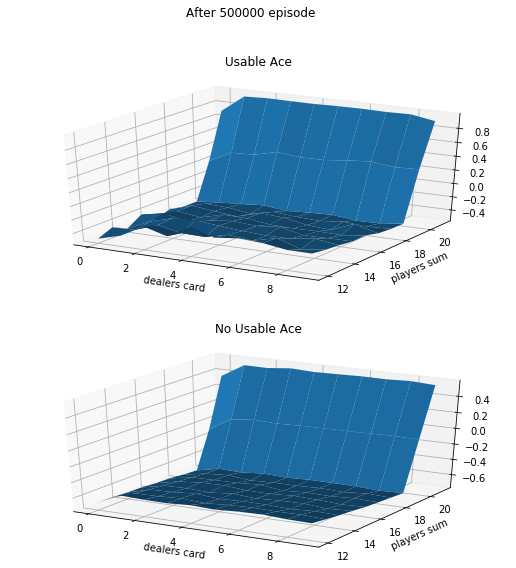

In [47]:
X, Y = np.meshgrid(np.arange(10), np.arange(12, 22))
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(211, projection='3d')
ax.title.set_text('Usable Ace')
ax.plot_surface(X, Y, ace_plot)
plt.xlabel('dealers card')
plt.ylabel('players sum')

ax = fig.add_subplot(212, projection='3d')
ax.title.set_text('No Usable Ace')
ax.plot_surface(X, Y, not_ace_plot)
plt.xlabel('dealers card')
plt.ylabel('players sum')

fig.suptitle('After ' + str(number_games) + ' episode', fontsize=12)


plt.show()

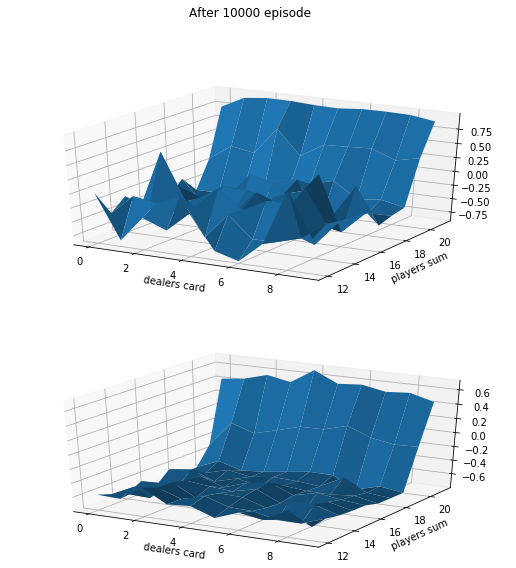

In [52]:
X, Y = np.meshgrid(np.arange(10), np.arange(12, 22))
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(211, projection='3d')
ax.plot_surface(X, Y, ace_plot)
plt.xlabel('dealers card')
plt.ylabel('players sum')

ax = fig.add_subplot(212, projection='3d')
ax.plot_surface(X, Y, not_ace_plot)
plt.xlabel('dealers card')
plt.ylabel('players sum')

fig.suptitle('After ' + str(number_games) + ' episode', fontsize=12)


plt.show()

In [54]:
q_not_ace = np.max(q[:,:,0,:], axis = -1)
q_ace = np.max(q[:,:,1,:], axis = -1)

pi_star_not_ace = np.argmax(q[:,:,0,:], axis = -1)
pi_star_ace = np.argmax(q[:,:,1,:], axis = -1)


In [56]:
pi_star_ace

array([[1, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [57]:
pi_star_not_ace

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])